In [16]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from matplotlib import pyplot as plt
import json
from qiskit_ibm_runtime import RuntimeEncoder

In [75]:
qc = QuantumCircuit(6)

qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.h(4)
qc.h(5)
# qc.h(6)

qc.cz(0, 1)
qc.cz(0, 2)
qc.cz(0, 3)
qc.cz(0, 4)
qc.cz(0, 5)
# qc.cz(0, 6)
print(qc)

     ┌───┐               
q_0: ┤ H ├─■──■──■──■──■─
     ├───┤ │  │  │  │  │ 
q_1: ┤ H ├─■──┼──┼──┼──┼─
     ├───┤    │  │  │  │ 
q_2: ┤ H ├────■──┼──┼──┼─
     ├───┤       │  │  │ 
q_3: ┤ H ├───────■──┼──┼─
     ├───┤          │  │ 
q_4: ┤ H ├──────────■──┼─
     ├───┤             │ 
q_5: ┤ H ├─────────────■─
     └───┘               


In [76]:
from qiskit.quantum_info import SparsePauliOp, StabilizerState, Pauli
 
observables_labels = ["YYYYYY", "YZYYYX", "YYZYYX", "YZZYYY", "ZYYYYX", "ZZYYYY", "ZYZYYY", "ZZZYYX"]
# ["ZZYZY", "YZZZY", "ZYZZY", "YYYZY", "ZZZYY", "YZYYY", "ZYYYY", "YYZYY"]
# ["ZZX", "ZZX", "ZYY", "ZYY", "YZY", "YZY", "YYX", "YYX"]
# ["ZZYY", "ZYZY", "ZZZX", "ZYYX", "YZZY", "YYYY", "YZYX", "YYZX"]
# ["YYYY", "YZYX", "ZYZY", "ZZZX", "YZZY", "YYZX", "ZZYY", "ZYYX"]
# ["YYYYYY", "YZYYYX", "YYZYYX", "YZZYYY", "ZYYYYX", "ZZYYYY", "ZYZYYY", "ZZZYYX"]
observables = [SparsePauliOp(label) for label in observables_labels]
service = QiskitRuntimeService(channel="ibm_quantum", token="9b7c0936e137c162b12a25c3f1072d408b2f6641620285606e154cd6168e0948aea4e56cec04a82bfbe24daf5306c6a02c81ed7e726d7d138b4732248b901f47")
# service = QiskitRuntimeService()

stab = StabilizerState(qc)
expected_values = [stab.expectation_value(Pauli(observable)) for observable in observables_labels]
 
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
# isa_circuit = qc
 
isa_circuit.draw('mpl', idle_wires=False)
 
estimator = Estimator(backend=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

In [77]:
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

# retrieved_job = service.job("cs3nkad75q40008ttejg")
# retrieved_job.result()
# print(retrieved_job)

# with open("result.json", "w") as file:
#     json.dump(retrieved_job.result(), file, cls=RuntimeEncoder)

 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
# retrieved_job = job.result()

# with open("another_result.json", "w") as file:
#     json.dump(retrieved_job.result(), file, cls=RuntimeEncoder)

>>> Job ID: cs58st74amg00087q8gg


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 623.1034379365619 quantum seconds, but you only have 332 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


In [80]:
print(f"Expected results: {expected_values}")
res = job.result()[0].data.evs
print(f"Results: {res}")
mse = 0
for i in range(len(observables)):
    mse += (res[i] - expected_values[i])**2
mse = mse / len(observables)
mse_minus = 0
for i in range(len(observables)):
    mse_minus += (res[i] + expected_values[i])**2
mse_minus = mse_minus / len(observables)
if mse_minus < mse:
    mse = mse_minus
    print("Inverse encoding is used")
print(f"Mean Squared Error: {mse}")

Expected results: [1, 1, 1, -1, 1, -1, -1, -1]
Results: [-0.05873823 -0.08458305  0.34949246 -0.40000734 -0.03759247  0.11101525
 -0.4211531  -0.48282825]
Mean Squared Error: 0.7492352057817722


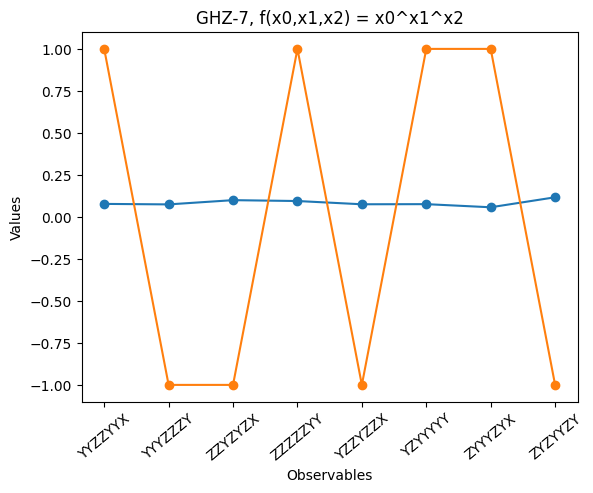

In [38]:
# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, '-o')
plt.plot(observables_labels, expected_values, '-o')
plt.xlabel('Observables')
plt.xticks(rotation=40)
plt.ylabel('Values')
plt.title('GHZ-7, f(x0,x1,x2) = x0^x1^x2')
plt.show()

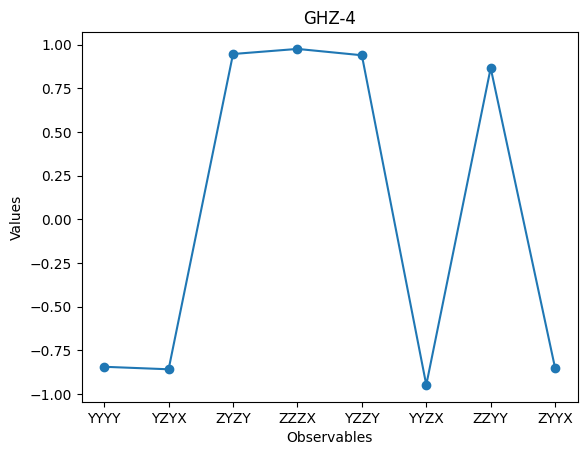

In [16]:
# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.title('GHZ-4')
plt.show()

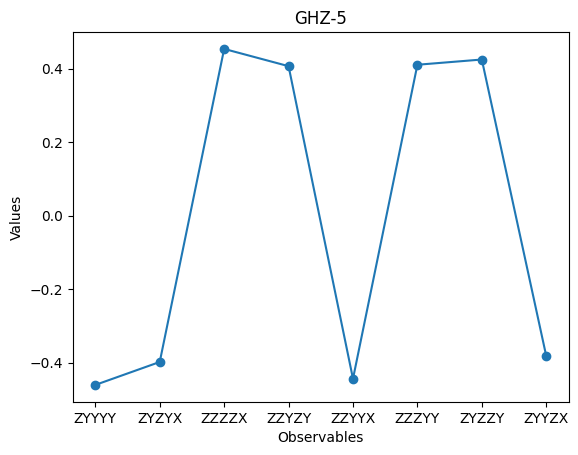

In [15]:
# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.title('GHZ-5')
plt.show()

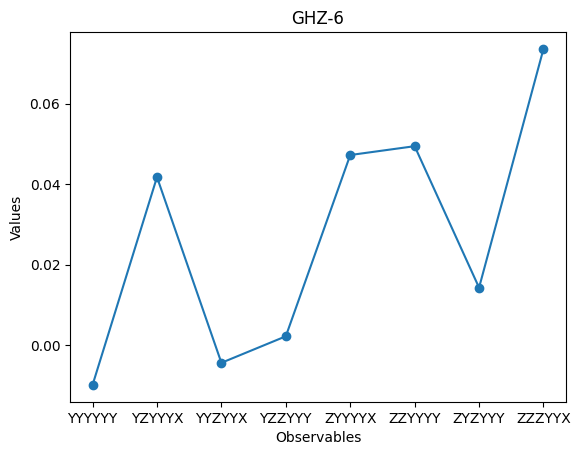

In [53]:
# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.title('GHZ-6')
plt.show()